# Example code

This script will:
- load all datasets into memory (takes a few seconds and around 1.3GB of RAM), 
- unwrap a specific dataset,
- preprocess it
- calculate the ensemble pairwise distance (PWD) map from single cell matrices
- plot it together with the pre-calculated KDE estimation of the ensemble PWD map

### loading datasets


In [1]:
import os
import numpy as np

data_path = '.'
data_file = 'dictData_small_211107.npy'

data = np.load(data_path + os.sep + data_file,allow_pickle=True)
data = data[()]
number_datasets=len(data)
print(f'Datasets read:{number_datasets}\n\nDatasets available:')

data_keys = list(data.keys())
for dataset in data_keys:
    print(f'{dataset}')


Datasets read:6

Datasets available:
doc_wt_nc11nc12_loRes_20_perROI_3D
doc_wt_nc14_loRes_20_perROI_3D
doc_wt_nc11nc12_hiRes_17_3D
doc_wt_nc14_hiRes_17_3D
HCT116_chr21-34-37Mb_untreated
HCT116_chr21-34-37Mb_6h auxin


### defines necessary functions

In [2]:
def shuffleMatrix2(matrix, index):
    '''
    this function will shuffle the barcodes if needed
    '''
    
    # if matrix is 2D, add a third dim
    numDims = len(matrix.shape)
    if numDims == 2:
        matrix = matrix[:,:,None]
    
    newSize = len(index)
    newMatrix = np.full((newSize,newSize,matrix.shape[2]), np.NaN)
    

    if not (newSize <= matrix.shape[0]):
        print("Error: shuffle size {} is larger than matrix dimensions {}".format(newSize, matrix.shape[0]))
        print("Shuffle: {} ".format(index))
        return newMatrix
    
    
    for i in range(newSize):
        for j in range(newSize):
            if (index[i] < matrix.shape[0]) and (index[j] < matrix.shape[0]):
                newMatrix[i, j, :] = matrix[index[i], index[j], :]
    
    if numDims == 2:
        newMatrix = newMatrix[:,:,0]
    
    return newMatrix

### Loads and preprocesses dataset

Processing doc_wt_nc11nc12_loRes_20_perROI_3D


/home/marcnol/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


0.3

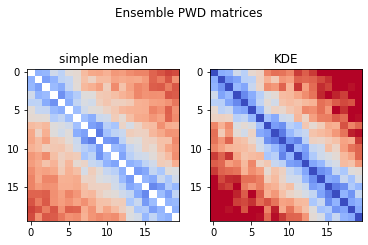

In [3]:
import matplotlib.pyplot as plt

distance_threshold=1
vmin,vmax = 0.3, 0.7 # values for matrix display
    
# gets new dataset
dataset_index = 0 # see list provided in first block to choose your dataset
datasetName = data_keys[dataset_index]
print(f'Processing {datasetName}')
pwd_sc_raw = data[datasetName]['pwd_sc_raw']

# shuffles barcode order if needed
if 'shuffle' in data[datasetName].keys():
    shuffle = data[datasetName]['shuffle']
    pwd_sc_raw = shuffleMatrix2(pwd_sc_raw, shuffle)

# converts to um
conversion_to_um = data[datasetName]['conversion_to_um']
pwd_sc_raw = conversion_to_um*pwd_sc_raw

# filtrers array
pwd_sc_raw[pwd_sc_raw > distance_threshold]=np.nan

# calculates median pairwise distances using nanmean
pwd_ensemble = np.nanmedian(pwd_sc_raw, axis=2) 

fig, ax = plt.subplots(1, 2)
fig.suptitle('Ensemble PWD matrices')
axes=ax.ravel()

axes[0].imshow(pwd_ensemble, cmap='coolwarm',vmin=vmin,vmax=vmax)
axes[0].set_title('simple median')

# retrieves KDE estimation if available
if 'KDE' in data[datasetName]:
    KDE = data[datasetName]['KDE'] # mean pairwise distance estimated with KDE
    axes[1].imshow(KDE, cmap='coolwarm',vmin=vmin,vmax=vmax)
    axes[1].set_title('KDE')
vmin